# CTGAN_on_minimum_instance

In [28]:
import numpy as np
import pandas as pd
from ctgan import CTGANSynthesizer
from model import Model
import gc

from sklearn import metrics
from sklearn import model_selection
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, KFold

In [70]:
list_column = ['salaire_mensuel_cleaned', 'anciennete_emploi_cleaned',
       'anciennete_bni_cleaned', 'categorie_employeur_cleaned_UNIQUEVAL',
       'mensualite_cleaned', 'argent_journalier',
       'taux_endettement_cleaned', 'salaire_vivable',
       'nb_salaires_cleaned', 'age_end', 'age_cleaned', 'nature_CAP_cleaned_UNIQUEVAL',
       'statut_marital_cleaned_UNIQUEVAL',
       'conventionne_cleaned_UNIQUEVAL', 'type_contrat_cleaned', 'duree_pret_cleaned', 'code_DTX_cleaned_UNIQUEVAL']

In [71]:
cat_col= ['categorie_employeur_cleaned_UNIQUEVAL','nature_CAP_cleaned_UNIQUEVAL',
       'statut_marital_cleaned_UNIQUEVAL',
       'conventionne_cleaned_UNIQUEVAL', 'type_contrat_cleaned','target']
cat_feat= [3,11,12,13,14]
num_col= ['salaire_mensuel_cleaned', 'anciennete_emploi_cleaned',
       'anciennete_bni_cleaned',
       'mensualite_cleaned', 'argent_journalier',
       'taux_endettement_cleaned', 'salaire_vivable',
       'nb_salaires_cleaned', 'age_end', 'age_cleaned', 'duree_pret_cleaned']

In [72]:
data_train = pd.read_csv('data/Version4/data_train_engv3_new.csv', delimiter=';')
data_train=data_train[list_column]
data_val = pd.read_csv('data/Version4/data_val_engv3_new.csv', delimiter=';')
data_val=data_val[list_column]
data_test = pd.read_csv('data/Version4/data_test_engv3_new.csv', delimiter=';')
data_test=data_test[list_column]

In [73]:
X_train = data_train.drop('code_DTX_cleaned_UNIQUEVAL', axis=1)
y_train = data_train['code_DTX_cleaned_UNIQUEVAL']
X_val = data_val.drop('code_DTX_cleaned_UNIQUEVAL', axis=1)
y_val = data_val['code_DTX_cleaned_UNIQUEVAL']
X_test = data_test.drop('code_DTX_cleaned_UNIQUEVAL', axis=1)
y_test = data_test['code_DTX_cleaned_UNIQUEVAL']

## Use of CTGAN to generate data (gan_xp)

In [6]:
def get_gan_dataset(x_train, y_train, x_test, cat_cols, gen_x_times=1.2, epochs=300):
    """
    Extends train by generating new data by GAN
    :param x_train:  train dataframe
    :param y_train: target for train dataframe
    :param x_test: dataframe
    :param cat_cols: List of categorical columns
    :param gen_x_times: Factor for which initial dataframe should be increased
    :param cat_cols: List of categorical columns
    :param epochs: Number of epoch max to train the GAN
    :return: generated data
    """

    if gen_x_times == 0:
        raise ValueError("Passed gen_x_times with value 0!")
    x_train["target"] = y_train
    x_test_bigger = int(1.1 * x_test.shape[0] / x_train.shape[0])
    print("x_test_bigger:",x_test_bigger)
    ctgan = CTGANSynthesizer()
    ctgan.fit(x_train, cat_cols, epochs=epochs)
    print("row numbers:",(x_test_bigger) * x_train.shape[0])
    generated_df = ctgan.sample((x_test_bigger) * x_train.shape[0])
    data_dtype = x_train.dtypes.values
    
    for i in range(len(generated_df.columns)):
        generated_df[generated_df.columns[i]] = generated_df[
            generated_df.columns[i]
        ].astype(data_dtype[i])
    
    return generated_df



### 10 minimum instances cause sample must >= n_components

In [74]:
X_test_instance=X_test.head(10)
y_test_instance=y_test.head(10)
X_test_instance

,salaire_mensuel_cleaned,anciennete_emploi_cleaned,anciennete_bni_cleaned,categorie_employeur_cleaned_UNIQUEVAL,mensualite_cleaned,argent_journalier,taux_endettement_cleaned,salaire_vivable,nb_salaires_cleaned,age_end,age_cleaned,nature_CAP_cleaned_UNIQUEVAL,statut_marital_cleaned_UNIQUEVAL,conventionne_cleaned_UNIQUEVAL,type_contrat_cleaned,duree_pret_cleaned
0,275800.00,73.0,30.0,1,90934.406378,6162.186454,32.971141,184865.593622,25.0,44.000000,41.0,1,0,1,0,36
1,500000.00,28.0,25.0,1,164950.000000,11168.333333,32.990000,335050.000000,25.0,28.000000,26.0,0,0,0,0,24
2,293674.06,86.0,46.0,1,94093.168824,6652.696373,32.040000,199580.891176,46.0,53.000000,50.0,0,0,0,0,36
3,160000.00,42.0,24.0,0,52560.000000,3581.333333,32.850000,107440.000000,22.0,24.000000,22.0,0,2,0,0,24
4,382966.00,111.0,9.0,3,125850.352980,8570.521567,32.862017,257115.647020,1.0,42.000000,37.0,0,0,0,0,60
5,140000.00,5.0,5.0,1,45724.000000,3142.533333,32.660000,94276.000000,4.0,42.000000,40.0,0,0,0,0,24
6,331140.00,11.0,8.0,3,108025.745956,7437.141801,32.622379,223114.254044,0.0,48.416667,47.0,0,1,1,1,17
7,402919.00,33.0,98.0,0,132761.810500,9005.239650,32.950000,270157.189500,66.0,50.000000,48.0,0,0,0,0,24
8,148179.00,138.0,44.0,1,47772.909600,3346.869680,32.240000,100406.090400,43.0,49.000000,47.0,1,0,0,0,24
9,180000.00,118.0,26.0,0,59346.000000,4021.800000,32.970000,120654.000000,24.0,58.000000,56.0,1,2,0,0,24


In [50]:
gan_train = get_gan_dataset(X_test_instance,y_test_instance,X_test_instance,cat_col)

/home/misa/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/misa/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/misa/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/misa/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing

x_test_bigger: 1


/home/misa/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/misa/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/misa/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/misa/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


GAN: Early stopping after epochs 67
row numbers: 10


In [51]:
gan_train.shape

(10, 17)

In [52]:
data_test.shape

(3028, 17)

In [53]:
gan_train

,salaire_mensuel_cleaned,anciennete_emploi_cleaned,anciennete_bni_cleaned,categorie_employeur_cleaned_UNIQUEVAL,mensualite_cleaned,argent_journalier,taux_endettement_cleaned,salaire_vivable,nb_salaires_cleaned,age_end,age_cleaned,nature_CAP_cleaned_UNIQUEVAL,statut_marital_cleaned_UNIQUEVAL,conventionne_cleaned_UNIQUEVAL,type_contrat_cleaned,duree_pret_cleaned,target
0,258689,112.731,6.15289,1,64782.2,11065.1,32.6468,46811.8,76.82,71.8512,27.2453,0,0,1,0,45.243,0
1,47572.2,41.5259,-23.3745,0,20632.4,-2700.72,32.7779,-19144.1,15.0963,63.6623,42.0508,0,0,1,1,28.1241,0
2,221190,152.517,-26.5676,1,-18002.8,8295.35,32.4938,-26758.9,29.8842,72.0817,40.5456,0,2,1,1,23.2188,0
3,411697,134.525,-18.5645,1,9816.37,-31.098,33.041,223902,60.9627,38.7597,22.7285,0,1,0,0,28.1021,0
4,137308,25.1261,-20.3941,1,133291,-1445.8,33.103,76506.8,70.6677,40.4194,17.4984,1,0,0,0,48.4106,0
5,391814,48.3136,-6.67576,0,26592.9,1321.91,33.2876,-45854.8,18.8936,50.5664,17.3246,0,0,0,0,46.9939,0
6,-59484.7,-25.6087,3.27518,3,13388.9,10498.6,33.1301,116487,54.9607,18.3372,23.3972,1,0,0,1,42.3233,0
7,17418.6,57.1822,-7.44773,0,-11435.7,7217.97,32.9872,-60876.4,55.1172,72.8712,15.1983,0,1,1,0,36.6618,0
8,-37901.8,31.5619,-11.4811,1,106950,4146.36,32.7846,111268,57.8319,34.9187,13.1606,0,0,1,0,34.5947,0
9,418949,110.825,-10.1237,0,-11639.3,7853.52,32.6936,373381,73.6195,54.236,22.0931,1,0,1,0,42.1155,0


In [63]:
data_test

,salaire_mensuel_cleaned,anciennete_emploi_cleaned,anciennete_bni_cleaned,categorie_employeur_cleaned_UNIQUEVAL,mensualite_cleaned,argent_journalier,taux_endettement_cleaned,salaire_vivable,nb_salaires_cleaned,age_end,age_cleaned,nature_CAP_cleaned_UNIQUEVAL,statut_marital_cleaned_UNIQUEVAL,conventionne_cleaned_UNIQUEVAL,type_contrat_cleaned,duree_pret_cleaned,code_DTX_cleaned_UNIQUEVAL
0,275800.00,73.0,30.0,1,90934.406378,6162.186454,32.971141,184865.593622,25.0,44.0,41.0,1,0,1,0,36,0
1,500000.00,28.0,25.0,1,164950.000000,11168.333333,32.990000,335050.000000,25.0,28.0,26.0,0,0,0,0,24,0
2,293674.06,86.0,46.0,1,94093.168824,6652.696373,32.040000,199580.891176,46.0,53.0,50.0,0,0,0,0,36,0
3,160000.00,42.0,24.0,0,52560.000000,3581.333333,32.850000,107440.000000,22.0,24.0,22.0,0,2,0,0,24,0
4,382966.00,111.0,9.0,3,125850.352980,8570.521567,32.862017,257115.647020,1.0,42.0,37.0,0,0,0,0,60,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3023,134000.00,149.0,19.0,0,44072.600000,2997.580000,32.890000,89927.400000,18.0,32.0,30.0,0,3,0,0,24,0
3024,84373.00,103.0,28.0,1,27193.417900,1905.986070,32.230000,57179.582100,27.0,48.0,46.0,0,0,0,0,24,0
3025,373000.00,93.0,71.0,1,108505.700000,8816.476667,29.090000,264494.300000,70.0,47.0,45.0,0,1,0,0,24,0
3026,128901.80,77.0,3.0,1,41622.391220,2909.313626,32.290000,87279.408780,3.0,33.0,30.0,0,0,0,0,36,0


In [64]:
gan_train.to_csv("results/dataset_gan_test_2.csv",sep=";")

### Import data gan test to avoid relaunch ctgan

In [65]:
gan_train = pd.read_csv("results/dataset_gan_test_2.csv",sep=";")

In [66]:
gan_train["target"].max()

1

In [67]:
data_copy = gan_train.drop(["Unnamed: 0","salaire_vivable","argent_journalier","age_end" ,"target"],axis=1)

In [68]:
data_copy['salaire_vivable'] = data_copy['salaire_mensuel_cleaned'] - data_copy['mensualite_cleaned']
data_copy['argent_journalier']= data_copy['salaire_vivable']/30
data_copy['age_end'] = data_copy['age_cleaned'] + (data_copy['duree_pret_cleaned']/12)

In [69]:
gan_xp = data_copy

### Evaluation of gan_xp based on true labels

In [109]:
def evaluate(data_train, data_test, list_column):
    #Training data on all data train
    data_train_used = pd.DataFrame()
    data_train_used = data_train[list_column]
    #Training model on all data_train
    data_train_used_dum = pd.get_dummies(data_train_used)
    features_train = data_train_used_dum.drop('code_DTX_cleaned_UNIQUEVAL', axis=1)
    target_train = data_train_used_dum['code_DTX_cleaned_UNIQUEVAL']
    model = GradientBoostingClassifier(learning_rate=0.05)
    model.fit(features_train, target_train)
    
    
    data_test_dum = pd.get_dummies(data_test)
    data_test_used = pd.DataFrame()
    for column in data_train_used_dum.columns:
        try:
            data_test_used[column] = data_test_dum[column]
        except KeyError:
            data_test_used[column] = np.zeros(len(data_test_dum))
    features_test = data_test_used.drop('code_DTX_cleaned_UNIQUEVAL', axis=1)
    target_test = data_test_used['code_DTX_cleaned_UNIQUEVAL']
    pred = model.predict_proba(features_test)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(target_test, pred)
    plt.plot(fpr, tpr)
    plt.legend(labels=[metrics.auc(fpr, tpr)])
    plt.show()
    return pred

In [55]:
def evaluate_cv(data, list_column):
    data_used = pd.DataFrame()
    data_used = data[list_column]
    #Removing year to list of columns
    
    X = data.drop('code_DTX_cleaned_UNIQUEVAL', axis=1).values
    y = data['code_DTX_cleaned_UNIQUEVAL'].values
    
    cv = KFold(n_splits=10,shuffle=True,random_state=42)
    GB = GradientBoostingClassifier(learning_rate=0.05)
    
    list_AUC = []
    list_abs = []
    i = 1
    for train, test in cv.split(X, y):
        GB.fit(X[train], y[train])
        pred = GB.predict_proba(X[test])[:, 1]
        fpr, tpr, thresholds = metrics.roc_curve(y[test], pred)
        list_AUC.append(metrics.auc(fpr, tpr))
        list_abs.append(i)
        i+=1
        plt.plot(fpr, tpr)
    print('Moyenne: ', np.mean(list_AUC))
    print('Std dev: ', np.std(list_AUC))
    plt.legend(labels=list_AUC)
    plt.show()

#### AUC of data_test

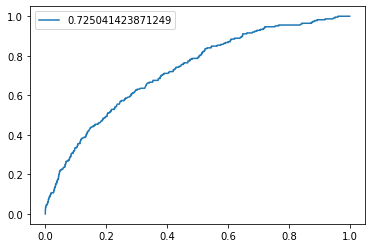

In [71]:
data = data_train
evaluate(data, data_test, list_column)

#### AUC of gan_xp with data_test labels

225


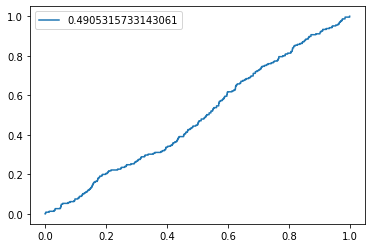

In [72]:
gan_xp['code_DTX_cleaned_UNIQUEVAL'] = data_test['code_DTX_cleaned_UNIQUEVAL']
print(gan_xp['code_DTX_cleaned_UNIQUEVAL'][gan_xp['code_DTX_cleaned_UNIQUEVAL'] == 1].count())
evaluate(data, gan_xp, list_column)

#### AUC of gan_xp with synth labels

In [93]:
gan_xp['code_DTX_cleaned_UNIQUEVAL'] = gan_train["target"]
#gan_xp.loc[gan_xp.code_DTX_cleaned_UNIQUEVAL >=1 , 'code_DTX_cleaned_UNIQUEVAL'] = 1
#gan_xp.loc[gan_xp.code_DTX_cleaned_UNIQUEVAL <1 , 'code_DTX_cleaned_UNIQUEVAL'] = 0
gan_xp['code_DTX_cleaned_UNIQUEVAL'][gan_xp['code_DTX_cleaned_UNIQUEVAL'] == 1].count()

358

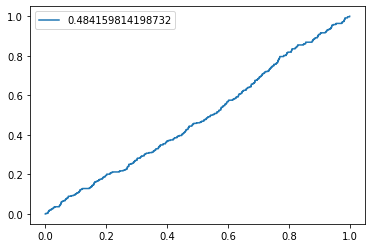

In [74]:
evaluate(data, gan_xp, list_column)

Moyenne:  0.5145386643967427
Std dev:  0.014177937588483543


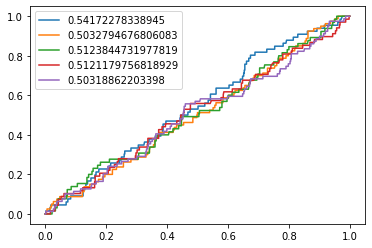

In [96]:
evaluate_cv(gan_xp,list_column)

### Try adversarial Training (data_train+data_synth) on data_test and data_synth_test
To improve model defense against adversarial attack

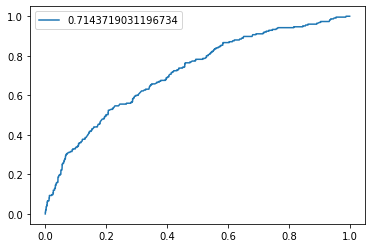

In [88]:
data_synth, data_synth_test = train_test_split(gan_xp, test_size=0.20, stratify=gan_xp['code_DTX_cleaned_UNIQUEVAL'])
data_extend = pd.concat([data_train,data_synth])
evaluate(data_extend, data_test, list_column)

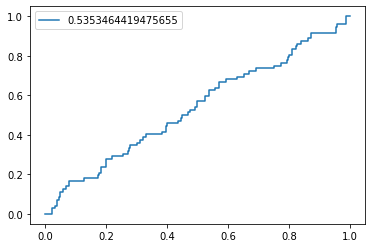

In [89]:
evaluate(data_extend, data_synth_test, list_column)

Moyenne:  0.6824843030655021
Std dev:  0.009455451766844524


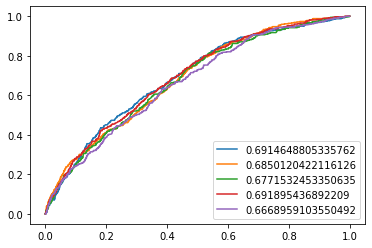

In [97]:
evaluate_cv(data_extend,list_column)

Constat : " La performance du modèle malgré l'ajout des instances synthétiques dans les données d'apprentissage n'améliore pas l'AUC sur l'évaluation du data_synth_test"

- Train : data_train 
    - AUC on data_test = 72
    - AUC on gan_xp (all data_synth) = 48.41


- Train : data_extend (data_train + 80% gan_xp)
    - AUC on data_test = 71
    - AUC on data_synth_test (20%) = 53.53
    
    
- CV :
    - CV on gan_xp = 51.45
    - CV on data_extend = 68.24 
    
TODO :
- Produire des datas synthétiques plus précis ; (Adversarial test)
- Augmenter le volume de datas générés 
____________________

## Methods for generating data for increasing train from "Diyago/GAN-for-tabular-data"

In [75]:
def extend_gan_train(x_train, y_train, x_test, cat_cols, num_cols ,gen_x_times=1.2, epochs=500):
    """
    Extends train by generating new data by GAN
    :param x_train:  train dataframe
    :param y_train: target for train dataframe
    :param x_test: dataframe
    :param cat_cols: List of categorical columns
    :param gen_x_times: Factor for which initial dataframe should be increased
    :param cat_cols: List of categorical columns
    :param epochs: Number of epoch max to train the GAN
    :return: extended train with target
    """

    if gen_x_times == 0:
        raise ValueError("Passed gen_x_times with value 0!")
    x_train["target"] = y_train
    x_test_bigger = int(1.1 * x_test.shape[0] / x_train.shape[0])
    ctgan = CTGANSynthesizer()
    ctgan.fit(x_train, cat_cols, epochs=epochs)
    generated_df = ctgan.sample((x_test_bigger) * x_train.shape[0])
    data_dtype = x_train.dtypes.values

    for i in range(len(generated_df.columns)):
        generated_df[generated_df.columns[i]] = generated_df[
            generated_df.columns[i]
        ].astype(data_dtype[i])

    generated_df = pd.concat(
        [
            x_train.sample(frac=(x_test_bigger), replace=True, random_state=42),
            generated_df,
        ]
    ).reset_index(drop=True)

    #num_cols = []
    #for col in x_train.columns:
    #    if "num" in col:
    #        num_cols.append(col)

    for num_col in num_cols:
        min_val = x_test[num_col].quantile(0.02)
        max_val = x_test[num_col].quantile(0.98)
        generated_df = generated_df.loc[
            (generated_df[num_col] >= min_val) & (generated_df[num_col] <= max_val)
        ]
    generated_df = generated_df.reset_index(drop=True)
    ad_model = adversarial_test(x_test, generated_df.drop("target", axis=1), cat_cols)

    generated_df["test_similarity"] = ad_model.predict(
        generated_df.drop("target", axis=1), return_shape=False
    )
    generated_df.sort_values("test_similarity", ascending=False, inplace=True)
    generated_df = generated_df.head(int(gen_x_times * x_train.shape[0]))
    x_train = pd.concat(
        [x_train, generated_df.drop("test_similarity", axis=1)], axis=0
    ).reset_index(drop=True)
    del generated_df
    gc.collect()
    return x_train.drop("target", axis=1), x_train["target"]



In [89]:
def get_min_gan(x_train, y_train, x_test, cat_cols, num_cols ,gen_x_times=1.2, epochs=500):
    """
    Extends train by generating new data by GAN
    :param x_train:  train dataframe
    :param y_train: target for train dataframe
    :param x_test: dataframe
    :param cat_cols: List of categorical columns
    :param gen_x_times: Factor for which initial dataframe should be increased
    :param cat_cols: List of categorical columns
    :param epochs: Number of epoch max to train the GAN
    :return: extended train with target
    """

    if gen_x_times == 0:
        raise ValueError("Passed gen_x_times with value 0!")
    x_train["target"] = y_train
    #x_test_bigger = int(1.1 * x_test.shape[0] / x_train.shape[0])
    x_test_bigger = 1
    ctgan = CTGANSynthesizer()
    ctgan.fit(x_train, cat_cols, epochs=epochs)
    generated_df = ctgan.sample((x_test_bigger) * x_train.shape[0])
    data_dtype = x_train.dtypes.values
    print(data_dtype)

    for i in range(len(generated_df.columns)):
        generated_df[generated_df.columns[i]] = generated_df[
            generated_df.columns[i]
        ].astype(data_dtype[i])

    generated_df = pd.concat(
        [
            x_train.sample(frac=(x_test_bigger), replace=True, random_state=42),
            generated_df,
        ]
    ).reset_index(drop=True)

    #num_cols = []
    #for col in x_train.columns:
    #    if "num" in col:
    #        num_cols.append(col)

    for num_col in num_cols:
        min_val = x_test[num_col].quantile(0.02)
        max_val = x_test[num_col].quantile(0.98)
        generated_df = generated_df.loc[
            (generated_df[num_col] >= min_val) & (generated_df[num_col] <= max_val)
        ]
    generated_df = generated_df.reset_index(drop=True)
    ad_model = adversarial_test(x_test, generated_df.drop("target", axis=1), cat_cols)

    generated_df["test_similarity"] = ad_model.predict(
        generated_df.drop("target", axis=1), return_shape=False
    )
    #generated_df.sort_values("test_similarity", ascending=False, inplace=True)
    #generated_df = generated_df.head(int(gen_x_times * x_train.shape[0]))
    x_train = pd.concat(
        [x_train, generated_df.drop("test_similarity", axis=1)], axis=0
    ).reset_index(drop=True)
    gen = generated_df.copy()
    del generated_df
    gc.collect()
    return x_train.drop("target", axis=1), x_train["target"], gen



In [90]:
def adversarial_test(left_df, right_df, cat_cols):
    """
    Trains adversarial model to distinguish train from test
    :param left_df:  dataframe
    :param right_df: dataframe
    :param cat_cols: List of categorical columns
    :return: trained model
    """
    # sample to shuffle the data
    left_df = left_df.copy().sample(frac=1).reset_index(drop=True)
    right_df = right_df.copy().sample(frac=1).reset_index(drop=True)

    left_df = left_df.head(right_df.shape[0])
    right_df = right_df.head(left_df.shape[0])

    left_df["gt"] = 0
    right_df["gt"] = 1

    concated = pd.concat([left_df, right_df])
    lgb_model = Model(
        cat_validation="Single",
        encoders_names=("OrdinalEncoder",),
        cat_cols=cat_cols,
        model_validation=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
        model_params={
            "metrics": "AUC",
            "max_depth": 2,
            "max_bin": 100,
            "n_estimators": 500,
            "learning_rate": 0.02,
            "random_state": 42,
        },
    )
    train_score, val_score, avg_num_trees = lgb_model.fit(
        concated.drop("gt", axis=1), concated["gt"]
    )

    print(
        "ROC AUC adversarial: train %.2f%% val %.2f%%"
        % (train_score * 100.0, val_score * 100.0)
    )
    return lgb_model

### minimum avec 100% données SAINS (head 10)

In [113]:
cat_col_1 = ['categorie_employeur_cleaned_UNIQUEVAL','nature_CAP_cleaned_UNIQUEVAL',
       'statut_marital_cleaned_UNIQUEVAL',
       'conventionne_cleaned_UNIQUEVAL', 'type_contrat_cleaned']

In [114]:
data_extend_2, data_extend_2_target, gan_data_min  = get_min_gan(X_test_instance,y_test_instance,X_val,cat_col_1,num_col,gen_x_times=1)

/home/misa/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/misa/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/misa/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/misa/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing

GAN: Early stopping after epochs 63
[dtype('float64') dtype('float64') dtype('float64') dtype('int64')
 dtype('float64') dtype('float64') dtype('float64') dtype('float64')
 dtype('float64') dtype('float64') dtype('float64') dtype('int64')
 dtype('int64') dtype('int64') dtype('int64') dtype('int64')
 dtype('int64')]


/home/misa/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/misa/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/misa/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
/home/misa/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/misa/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Referenc

Mean score train : 0.5
Mean score val : 0.5
ROC AUC adversarial: train 50.00% val 50.00%


/home/misa/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/misa/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


In [152]:
#gan_data['target'] = data_extend_1_target
gan_data_min.to_csv("results/gan_data_test_min_sains.csv",sep=";")
test_instances = X_test_instance
test_instances['code_DTX_cleaned_UNIQUEVAL'] = y_test_instance
test_instances.to_csv("results/original_data_min.csv",sep=";")

In [153]:
test_instances

,salaire_mensuel_cleaned,anciennete_emploi_cleaned,anciennete_bni_cleaned,categorie_employeur_cleaned_UNIQUEVAL,mensualite_cleaned,argent_journalier,taux_endettement_cleaned,salaire_vivable,nb_salaires_cleaned,age_end,age_cleaned,nature_CAP_cleaned_UNIQUEVAL,statut_marital_cleaned_UNIQUEVAL,conventionne_cleaned_UNIQUEVAL,type_contrat_cleaned,duree_pret_cleaned,target,code_DTX_cleaned_UNIQUEVAL
0,275800.00,73.0,30.0,1,90934.406378,6162.186454,32.971141,184865.593622,25.0,44.0,41.0,1,0,1,0,36,0,0
1,500000.00,28.0,25.0,1,164950.000000,11168.333333,32.990000,335050.000000,25.0,28.0,26.0,0,0,0,0,24,0,0
2,293674.06,86.0,46.0,1,94093.168824,6652.696373,32.040000,199580.891176,46.0,53.0,50.0,0,0,0,0,36,0,0
3,160000.00,42.0,24.0,0,52560.000000,3581.333333,32.850000,107440.000000,22.0,24.0,22.0,0,2,0,0,24,0,0
4,382966.00,111.0,9.0,3,125850.352980,8570.521567,32.862017,257115.647020,1.0,42.0,37.0,0,0,0,0,60,0,0
66,160000.00,10.0,4.0,0,50800.000000,3640.000000,31.750000,109200.000000,2.0,40.0,38.0,0,0,0,0,24,1,1
103,347065.31,162.0,103.0,0,114010.954335,7768.478522,32.850000,233054.355665,89.0,51.0,48.0,1,0,0,0,36,1,1
109,357028.39,38.0,27.0,1,116926.797725,8003.386409,32.750000,240101.592275,27.0,28.0,26.0,0,1,0,0,24,1,1
116,228604.00,67.0,41.0,2,75439.320000,5105.489333,33.000000,153164.680000,41.0,40.0,35.0,1,1,0,0,60,1,1
155,103229.91,44.0,5.0,0,34024.578336,2306.844389,32.960000,69205.331664,4.0,29.0,27.0,0,0,0,0,24,1,1


### Import data gan test to avoid relaunch ctgan

In [116]:
gan_data_min = pd.read_csv("results/gan_data_test_min_sains.csv",sep=";")

In [117]:
gan_data_min.head(15)

,Unnamed: 0,salaire_mensuel_cleaned,anciennete_emploi_cleaned,anciennete_bni_cleaned,categorie_employeur_cleaned_UNIQUEVAL,mensualite_cleaned,argent_journalier,taux_endettement_cleaned,salaire_vivable,nb_salaires_cleaned,age_end,age_cleaned,nature_CAP_cleaned_UNIQUEVAL,statut_marital_cleaned_UNIQUEVAL,conventionne_cleaned_UNIQUEVAL,type_contrat_cleaned,duree_pret_cleaned,target,test_similarity
0,0,402919.00,33.0,98.0,0,132761.810500,9005.239650,32.950000,270157.189500,66.0,50.0,48.0,0,0,0,0,24,0,10.5
1,1,382966.00,111.0,9.0,3,125850.352980,8570.521567,32.862017,257115.647020,1.0,42.0,37.0,0,0,0,0,60,0,10.5
2,2,180000.00,118.0,26.0,0,59346.000000,4021.800000,32.970000,120654.000000,24.0,58.0,56.0,1,2,0,0,24,0,10.5
3,3,293674.06,86.0,46.0,1,94093.168824,6652.696373,32.040000,199580.891176,46.0,53.0,50.0,0,0,0,0,36,0,10.5
4,4,402919.00,33.0,98.0,0,132761.810500,9005.239650,32.950000,270157.189500,66.0,50.0,48.0,0,0,0,0,24,0,10.5
5,5,382966.00,111.0,9.0,3,125850.352980,8570.521567,32.862017,257115.647020,1.0,42.0,37.0,0,0,0,0,60,0,10.5


In [118]:
X_test_instance

,salaire_mensuel_cleaned,anciennete_emploi_cleaned,anciennete_bni_cleaned,categorie_employeur_cleaned_UNIQUEVAL,mensualite_cleaned,argent_journalier,taux_endettement_cleaned,salaire_vivable,nb_salaires_cleaned,age_end,age_cleaned,nature_CAP_cleaned_UNIQUEVAL,statut_marital_cleaned_UNIQUEVAL,conventionne_cleaned_UNIQUEVAL,type_contrat_cleaned,duree_pret_cleaned,target
0,275800.00,73.0,30.0,1,90934.406378,6162.186454,32.971141,184865.593622,25.0,44.000000,41.0,1,0,1,0,36,0
1,500000.00,28.0,25.0,1,164950.000000,11168.333333,32.990000,335050.000000,25.0,28.000000,26.0,0,0,0,0,24,0
2,293674.06,86.0,46.0,1,94093.168824,6652.696373,32.040000,199580.891176,46.0,53.000000,50.0,0,0,0,0,36,0
3,160000.00,42.0,24.0,0,52560.000000,3581.333333,32.850000,107440.000000,22.0,24.000000,22.0,0,2,0,0,24,0
4,382966.00,111.0,9.0,3,125850.352980,8570.521567,32.862017,257115.647020,1.0,42.000000,37.0,0,0,0,0,60,0
5,140000.00,5.0,5.0,1,45724.000000,3142.533333,32.660000,94276.000000,4.0,42.000000,40.0,0,0,0,0,24,0
6,331140.00,11.0,8.0,3,108025.745956,7437.141801,32.622379,223114.254044,0.0,48.416667,47.0,0,1,1,1,17,0
7,402919.00,33.0,98.0,0,132761.810500,9005.239650,32.950000,270157.189500,66.0,50.000000,48.0,0,0,0,0,24,0
8,148179.00,138.0,44.0,1,47772.909600,3346.869680,32.240000,100406.090400,43.0,49.000000,47.0,1,0,0,0,24,0
9,180000.00,118.0,26.0,0,59346.000000,4021.800000,32.970000,120654.000000,24.0,58.000000,56.0,1,2,0,0,24,0


In [119]:
data_copy = gan_data_min.drop(["Unnamed: 0","salaire_vivable","argent_journalier","age_end" ,"target"],axis=1)

In [120]:
data_copy['salaire_vivable'] = data_copy['salaire_mensuel_cleaned'] - data_copy['mensualite_cleaned']
data_copy['argent_journalier']= data_copy['salaire_vivable']/30
data_copy['age_end'] = data_copy['age_cleaned'] + (data_copy['duree_pret_cleaned']/12)

In [121]:
gan_xp_3 = data_copy

In [122]:
gan_xp_3['code_DTX_cleaned_UNIQUEVAL'] = gan_data_min["target"]

/home/misa/.local/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


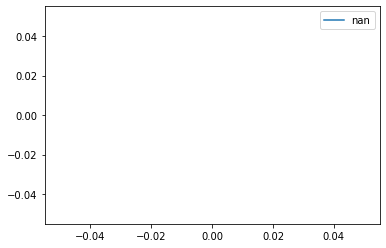

In [123]:
data = data_train
pred = evaluate(data, gan_xp_3, list_column)

In [124]:
gan_xp_3['code_DTX_cleaned_UNIQUEVAL']

0    0
1    0
2    0
3    0
4    0
5    0
Name: code_DTX_cleaned_UNIQUEVAL, dtype: int64

In [125]:
gan_xp_3["pred"]=pred

In [126]:
gan_xp_3["pred"]

0    0.054664
1    0.030761
2    0.095715
3    0.040092
4    0.054664
5    0.030761
Name: pred, dtype: float64

### Minimum avec 50% données SAINS

In [135]:
X_test_instance=X_test.head(5)
y_test_instance=y_test.head(5)
tmp = data_test[data_test['code_DTX_cleaned_UNIQUEVAL'] == 1 ]
tmp_X = tmp.drop('code_DTX_cleaned_UNIQUEVAL',axis=1)
tmp_y = tmp['code_DTX_cleaned_UNIQUEVAL']
X_test_instance = pd.concat([X_test_instance,tmp_X.head(5)])
y_test_instance = pd.concat([y_test_instance,tmp_y.head(5)])
y_test_instance

0      0
1      0
2      0
3      0
4      0
66     1
103    1
109    1
116    1
155    1
Name: code_DTX_cleaned_UNIQUEVAL, dtype: int64

In [136]:
cat_col_1 = ['categorie_employeur_cleaned_UNIQUEVAL','nature_CAP_cleaned_UNIQUEVAL',
       'statut_marital_cleaned_UNIQUEVAL',
       'conventionne_cleaned_UNIQUEVAL', 'type_contrat_cleaned']

In [137]:
data_extend_2, data_extend_2_target, gan_data_min  = get_min_gan(X_test_instance,y_test_instance,X_val,cat_col_1,num_col,gen_x_times=1)

/home/misa/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/misa/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/misa/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/misa/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/misa/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarn

GAN: Early stopping after epochs 94
[dtype('float64') dtype('float64') dtype('float64') dtype('int64')
 dtype('float64') dtype('float64') dtype('float64') dtype('float64')
 dtype('float64') dtype('float64') dtype('float64') dtype('int64')
 dtype('int64') dtype('int64') dtype('int64') dtype('int64')
 dtype('int64')]


/home/misa/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/misa/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/misa/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
/home/misa/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/misa/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Referenc

Mean score train : 0.5
Mean score val : 0.5
ROC AUC adversarial: train 50.00% val 50.00%


/home/misa/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/misa/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


In [138]:
#gan_data['target'] = data_extend_1_target
gan_data_min.to_csv("results/gan_data_test_min.csv",sep=";")

### Import data gan test to avoid relaunch ctgan

In [139]:
gan_data_min = pd.read_csv("results/gan_data_test_min.csv",sep=";")

In [141]:
gan_data_min.head(15)

,Unnamed: 0,salaire_mensuel_cleaned,anciennete_emploi_cleaned,anciennete_bni_cleaned,categorie_employeur_cleaned_UNIQUEVAL,mensualite_cleaned,argent_journalier,taux_endettement_cleaned,salaire_vivable,nb_salaires_cleaned,age_end,age_cleaned,nature_CAP_cleaned_UNIQUEVAL,statut_marital_cleaned_UNIQUEVAL,conventionne_cleaned_UNIQUEVAL,type_contrat_cleaned,duree_pret_cleaned,target,test_similarity
0,0,347065.310000,162.000000,103.000000,0,114010.954335,7768.478522,32.850000,233054.355665,89.000000,51.000000,48.000000,1,0,0,0,36,1,18.0
1,1,357028.390000,38.000000,27.000000,1,116926.797725,8003.386409,32.750000,240101.592275,27.000000,28.000000,26.000000,0,1,0,0,24,1,18.0
2,2,382966.000000,111.000000,9.000000,3,125850.352980,8570.521567,32.862017,257115.647020,1.000000,42.000000,37.000000,0,0,0,0,60,0,18.0
3,3,347065.310000,162.000000,103.000000,0,114010.954335,7768.478522,32.850000,233054.355665,89.000000,51.000000,48.000000,1,0,0,0,36,1,18.0
4,4,103229.910000,44.000000,5.000000,0,34024.578336,2306.844389,32.960000,69205.331664,4.000000,29.000000,27.000000,0,0,0,0,24,1,18.0
5,5,293674.060000,86.000000,46.000000,1,94093.168824,6652.696373,32.040000,199580.891176,46.000000,53.000000,50.000000,0,0,0,0,36,0,18.0
6,6,347065.310000,162.000000,103.000000,0,114010.954335,7768.478522,32.850000,233054.355665,89.000000,51.000000,48.000000,1,0,0,0,36,1,18.0
7,7,357028.390000,38.000000,27.000000,1,116926.797725,8003.386409,32.750000,240101.592275,27.000000,28.000000,26.000000,0,1,0,0,24,1,18.0
8,8,382966.000000,111.000000,9.000000,3,125850.352980,8570.521567,32.862017,257115.647020,1.000000,42.000000,37.000000,0,0,0,0,60,0,18.0
9,9,480158.096699,134.144255,17.322267,1,96670.797612,12963.493460,32.758436,286358.521496,30.727229,51.400538,34.378619,1,2,0,0,37,0,18.0


In [142]:
X_test_instance

,salaire_mensuel_cleaned,anciennete_emploi_cleaned,anciennete_bni_cleaned,categorie_employeur_cleaned_UNIQUEVAL,mensualite_cleaned,argent_journalier,taux_endettement_cleaned,salaire_vivable,nb_salaires_cleaned,age_end,age_cleaned,nature_CAP_cleaned_UNIQUEVAL,statut_marital_cleaned_UNIQUEVAL,conventionne_cleaned_UNIQUEVAL,type_contrat_cleaned,duree_pret_cleaned,target
0,275800.00,73.0,30.0,1,90934.406378,6162.186454,32.971141,184865.593622,25.0,44.0,41.0,1,0,1,0,36,0
1,500000.00,28.0,25.0,1,164950.000000,11168.333333,32.990000,335050.000000,25.0,28.0,26.0,0,0,0,0,24,0
2,293674.06,86.0,46.0,1,94093.168824,6652.696373,32.040000,199580.891176,46.0,53.0,50.0,0,0,0,0,36,0
3,160000.00,42.0,24.0,0,52560.000000,3581.333333,32.850000,107440.000000,22.0,24.0,22.0,0,2,0,0,24,0
4,382966.00,111.0,9.0,3,125850.352980,8570.521567,32.862017,257115.647020,1.0,42.0,37.0,0,0,0,0,60,0
66,160000.00,10.0,4.0,0,50800.000000,3640.000000,31.750000,109200.000000,2.0,40.0,38.0,0,0,0,0,24,1
103,347065.31,162.0,103.0,0,114010.954335,7768.478522,32.850000,233054.355665,89.0,51.0,48.0,1,0,0,0,36,1
109,357028.39,38.0,27.0,1,116926.797725,8003.386409,32.750000,240101.592275,27.0,28.0,26.0,0,1,0,0,24,1
116,228604.00,67.0,41.0,2,75439.320000,5105.489333,33.000000,153164.680000,41.0,40.0,35.0,1,1,0,0,60,1
155,103229.91,44.0,5.0,0,34024.578336,2306.844389,32.960000,69205.331664,4.0,29.0,27.0,0,0,0,0,24,1


In [143]:
data_copy = gan_data_min.drop(["Unnamed: 0","salaire_vivable","argent_journalier","age_end" ,"target"],axis=1)

In [144]:
data_copy['salaire_vivable'] = data_copy['salaire_mensuel_cleaned'] - data_copy['mensualite_cleaned']
data_copy['argent_journalier']= data_copy['salaire_vivable']/30
data_copy['age_end'] = data_copy['age_cleaned'] + (data_copy['duree_pret_cleaned']/12)

In [145]:
gan_xp_3 = data_copy

In [146]:
gan_xp_3['code_DTX_cleaned_UNIQUEVAL'] = gan_data_min["target"]

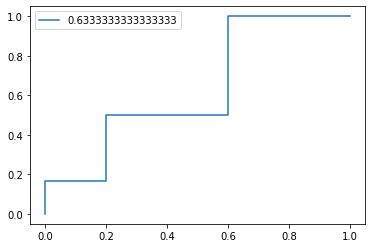

In [147]:
data = data_train
pred = evaluate(data, gan_xp_3, list_column)

In [148]:
gan_xp_3['code_DTX_cleaned_UNIQUEVAL']

0     1
1     1
2     0
3     1
4     1
5     0
6     1
7     1
8     0
9     0
10    0
Name: code_DTX_cleaned_UNIQUEVAL, dtype: int64

In [149]:
gan_xp_3["pred"]=pred

In [150]:
gan_xp_3["pred"]

0     0.035788
1     0.061839
2     0.030761
3     0.035788
4     0.159157
5     0.040092
6     0.035788
7     0.061839
8     0.030761
9     0.048668
10    0.073310
Name: pred, dtype: float64

In [154]:
gan_xp_3.to_csv("results/gan_data_test_min_corrected.csv",sep=";")